# Examen Python Data Developer
# Deel 2

Ga verder met de verwerkte data die je uit deel 1 hebt. We gaan nu op basis van dezelfde dataset een aantal onderzoeksvragen oplossen!

In [173]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt 
from tqdm import tqdm
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Importing & loading plot style settings
sys.path.append('../scripts/utilities')
from standard_style import standard_style
standard_style()

# Definieer data locaties
input_path = os.path.join('..', 'data', 'input')
output_path = os.path.join('..', 'data', 'output')

### Utilities

In [95]:

def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))
  
# Functie om unisex namen te identificeren en de aantalen per geslacht
def get_unisex_names(dataframe):
    gender_counts = dataframe.groupby(['naam', 'geslacht']).size().unstack(fill_value=0)
    unisex_names = gender_counts[(gender_counts['Mannelijk'] > 0) & (gender_counts['Vrouwelijk'] > 0)].index
    return unisex_names, gender_counts

# Functie die de meest voorkomende unisex namen per geslacht bepaalt en returneert
def most_common_unisex_names(dataframe, unisex_names):
    # Filter the dataframe to only include unisex names
    unisex_df = dataframe[dataframe['naam'].isin(unisex_names)]
    
    # Overall most common unisex name
    overall_common_name = unisex_df['naam'].value_counts().idxmax()
    
    # Filter dataframes on gender to get most common unisex names for both genders
    male_unisex_df = unisex_df[unisex_df['geslacht'] == 'Mannelijk']
    female_unisex_df = unisex_df[unisex_df['geslacht'] == 'Vrouwelijk']
    male_common_name = male_unisex_df['naam'].value_counts().idxmax()
    female_common_name = female_unisex_df['naam'].value_counts().idxmax()
    
    return (overall_common_name, male_common_name, female_common_name)

# Functie om "echte" unisex namen te filteren - dus met een verschil van minder dan 50% in aantal voorkomens tussen mannen en vrouwen
def get_real_unisex_names(gender_counts):
    real_unisex_names = gender_counts[
        (gender_counts['Mannelijk'] <= 1.5 * gender_counts['Vrouwelijk']) &
        (gender_counts['Vrouwelijk'] <= 1.5 * gender_counts['Mannelijk'])
        ].index
    return real_unisex_names

# Functie om het percentage mannen en vrouwen met een echte unisex naam te berekenen
def gender_percentage_real_unisex(dataframe, real_unisex_names):
    real_unisex_df = dataframe[dataframe['naam'].isin(real_unisex_names)]
    male_count = real_unisex_df[real_unisex_df['geslacht'] == 'Mannelijk'].shape[0]
    female_count = real_unisex_df[real_unisex_df['geslacht'] == 'Vrouwelijk'].shape[0]
    
    total_male = dataframe[dataframe['geslacht'] == 'Mannelijk'].shape[0]
    total_female = dataframe[dataframe['geslacht'] == 'Vrouwelijk'].shape[0]
    
    male_percentage = (male_count / total_male) * 100
    female_percentage = (female_count / total_female) * 100
    
    return male_percentage, female_percentage


### Loading data

In [96]:
dfs = list()
for filename in os.listdir(input_path):
    df = pd.read_csv(os.path.join(input_path,filename))
    df['geboorte_datum'] = filename.strip('.csv')
    dfs.append(df)

df_raw = pd.concat(dfs, ignore_index=True)
geboortes = df_raw.copy()

### Preprocessing

In [215]:
def clean_df(df):
    # Rename columns
    df = df.rename(columns={'verwachte datum': 'verwachte_datum'})
    
    # Put outlier dates in separate dataframe
    outlier_datums = ['2019-2-29','2019-1-1', '2019-7-1']
    df_wrong = df.loc[df['geboorte_datum'].isin(outlier_datums)].copy()
    
    # Remove outlier dates from original dataframe
    df = df.loc[~df['geboorte_datum'].isin(outlier_datums)].copy()
    
    # Convert columns containing dates to datetime
    df['geboorte_datum'] = pd.to_datetime(df['geboorte_datum'])	
    df['verwachte_datum'] = pd.to_datetime(df['verwachte_datum'])	
    df['geslacht'] = df['geslacht'].astype('category')
    df['date_diff'] = (df['geboorte_datum'] - df['verwachte_datum']).dt.days

    df['dag_van_jaar'] = df['geboorte_datum'].dt.dayofyear
    df['verwachte_dag_van_jaar'] = df['verwachte_datum'].dt.dayofyear

    # Adjust 'verwachte_dag_van_jaar' in case the year of the expected birthdate is different than the year of the birthdate
    condition = (df['verwachte_datum'].dt.year > df['geboorte_datum'].dt.year)
    df.loc[condition, 'verwachte_dag_van_jaar'] += 365
    condition = (df['verwachte_datum'].dt.year < df['geboorte_datum'].dt.year)
    df.loc[condition, 'verwachte_dag_van_jaar'] -= 365

    # Adding absolute difference in days between birthdate and expected birthdate
    df['abs_date_diff'] = df['date_diff'].abs()

    return df

### Onderzoek 1: Unisex namen
#### Een aantal statistieken
Sommige namen zijn unisex, dat wil zeggen dat zij hetzelfde zijn voor mannen en vrouwen. Beantwoord volgende 3 vragen over unisex namen in onze dataset:
 - Hoeveel unisex namen zijn er?
 - Wat is de meest voorkomende unisex naam; hiervoor zoek ik 3 namen (en getallen):
    - De meest populaire unisex naam bij mannen.
    - De meest populaire unisex naam bij vrouwen.
    - De meest popuaire unisex naam.

**Tip:** Neem hiervoor terug de volledige dataset in acht (dus met de foutief geklasseerde namen).

In [98]:
# Identify unisex names
unisex_names, _ = get_unisex_names(geboortes)

# Count unisex names
unisex_name_count = len(unisex_names)

# Find the most common unisex names per gender
overall_common_name, male_common_name, female_common_name = most_common_unisex_names(geboortes, unisex_names)

# Display the results
print(f"Number of unisex names: {unisex_name_count}")
print(f"Populairste unisex naam bij de mannen: {male_common_name}")
print(f"Populairste unisex naam bij de vrouwen: {female_common_name}")
print(f"Populairse echte unisex naam in het algemeen: {overall_common_name}")

Number of unisex names: 75
Populairste unisex naam bij de mannen: Maxime
Populairste unisex naam bij de vrouwen: Dominique
Populairse echte unisex naam in het algemeen: Dominique


Populairse unisex naam bij de mannen: Maxime
Populairse unisex naam bij de vrouwen: Dominique
Populairse unisex naam in het algemeen: Dominique


We zien dat er een vrij groot aantal namen veel meer voorkomen bij mannen dan vrouwen (en omgekeerd). Dit vinden we eigenlijk geen "echte" unisex namen. We noemen een naam "echt unisex" als de naam niet meer dan 50% meer voorkomt bij 1 van de 2 geslachten. Dus als er `x` mannen en `y` vrouwen zijn genaamd Chris, dan noemen we Chris "echt unisex" als `x <= 1.5 * y` en `y <= x * 1.5`. Filter je unisex dataframe tot een `df_real_unisex` waarbij je enkel de "echte" unisex namen weerhoudt. 
- Beantwoord nu bovenstaande 3 vragen opnieuw voor deze dataset. Hierbij werk je best met een functie zodat je geen code moet herhalen!
- Zijn de echte unisex namen populairder bij mannen of vrouwen, of is de populariteit hetzelfde? Deze vraag kan je beantwoorden door te kijken naar het percentage mannen/vrouwen met een echte unisex naam.

In [99]:
# Identificeer unisex namen
_, gender_counts = get_unisex_names(geboortes)

# Filter om echte unisex namen te krijgen
real_unisex_names = get_real_unisex_names(gender_counts)

# Beantwoord de 3 vragen opnieuw voor echte unisex namen
overall_common_name, male_common_name, female_common_name = most_common_unisex_names(geboortes, real_unisex_names)

# Visualiseer de resultaten
print(f"Aantal echte unisex namen: {len(real_unisex_names)}")
print(f"Meest populaire echte unisex naam overall: {overall_common_name}")
print(f"Meest populaire echte unisex naam bij mannen: {male_common_name}")
print(f"Meest populaire echte unisex naam bij vrouwen: {female_common_name}")

Aantal echte unisex namen: 14
Meest populaire echte unisex naam overall: Dominique
Meest populaire echte unisex naam bij mannen: Dominique
Meest populaire echte unisex naam bij vrouwen: Dominique


Populairse echte unisex naam bij de mannen: Dominique
Populairse echte unisex naam bij de vrouwen: Dominique
Populairse echte unisex naam in het algemeen: Dominique


In [100]:
# Bereken het percentage mannen en vrouwen met een echte unisex naam
male_percentage, female_percentage = gender_percentage_real_unisex(geboortes, real_unisex_names)
print(f"Percentage mannen met een echte unisex naam: {male_percentage:.1f}%")
print(f"Percentage vrouwen met een echte unisex naam: {female_percentage:.1f}%")

Percentage mannen met een echte unisex naam: 0.4%
Percentage vrouwen met een echte unisex naam: 0.5%


Percentage mannen met unisex naam: 0.4%
Percentage vrouwen met unisex naam: 0.5%


#### Visualizatie

    Maak een visualizatie die alle echte unisex namen toont en de relatieve voorkomens bij mannen en vrouwen.

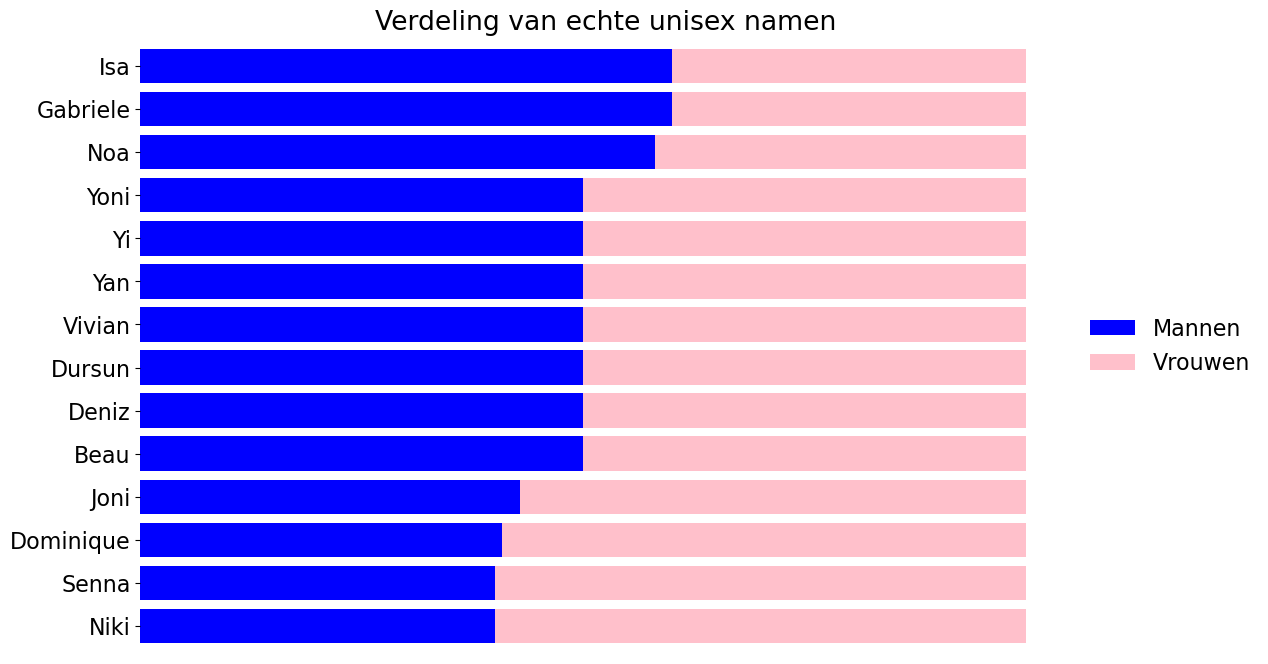

In [225]:
# Function to plot real unisex names
def plot_real_unisex_names(dataframe, real_unisex_names):
    # Fitler the dataframe to only include real unisex names
    real_unisex_counts = dataframe[dataframe['naam'].isin(real_unisex_names)].groupby(['naam', 'geslacht']).size().unstack(fill_value=0)
    
    # Normalize the values to represent percentages
    real_unisex_counts['Totaal'] = real_unisex_counts.sum(axis=1)
    real_unisex_counts['Mannelijk %'] = real_unisex_counts['Mannelijk'] / real_unisex_counts['Totaal']
    real_unisex_counts['Vrouwelijk %'] = real_unisex_counts['Vrouwelijk'] / real_unisex_counts['Totaal']
    
    # Sort the data by the percentage of male occurrences in descending order
    sorted_normalized_counts = real_unisex_counts.sort_values(by='Mannelijk %', ascending=True)
    
    # Create a horizontal bar plot
    fig, ax = plt.subplots(figsize=(12, 8))
    sorted_normalized_counts[['Mannelijk %', 'Vrouwelijk %']].plot(kind='barh', stacked=True, ax=ax, color=['blue', 'pink'], width=0.8)

    # Set labels and title
    ax.set_ylabel('')
    ax.set_title('Verdeling van echte unisex namen')
    
    # Remove x-axis labels
    ax.set_xticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Position the legend to the right
    ax.legend(['Mannen', 'Vrouwen'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Example usage
plot_real_unisex_names(geboortes, real_unisex_names)

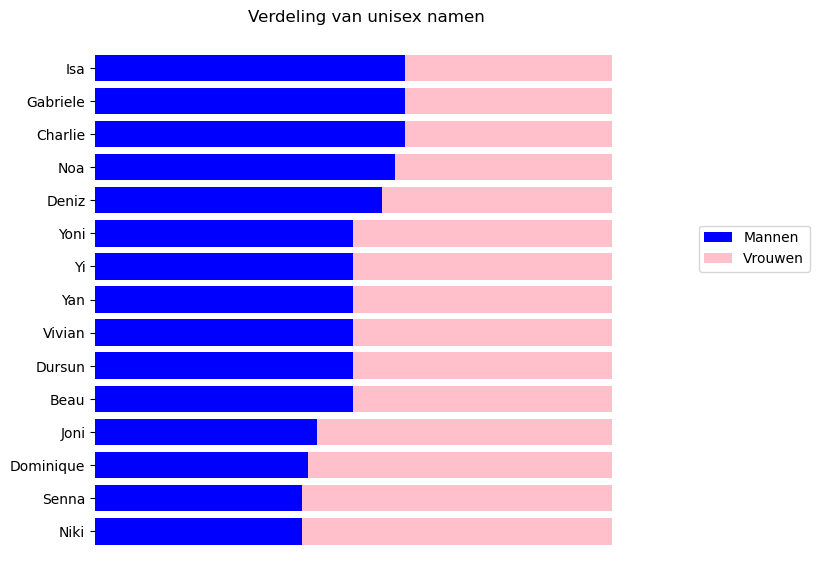

### Onderzoek 2: de accuraatheid van de geschatte bevallingsdatum
#### Evolutie vergelijken

Maak een afbeelding van het totaal aantal geboortes per dag en het totaal aantal verwachte geboortes.

**Bonusvraag**: Gewoon om over na te denken: waarom zien de uiteindes van je plot er wat gek uit? Schrijf het antwoord neer in een strategisch geplaatste markdown cel.

In [216]:
# First clean the dataframe to start working with dates
geboortes_clean = clean_df(geboortes)

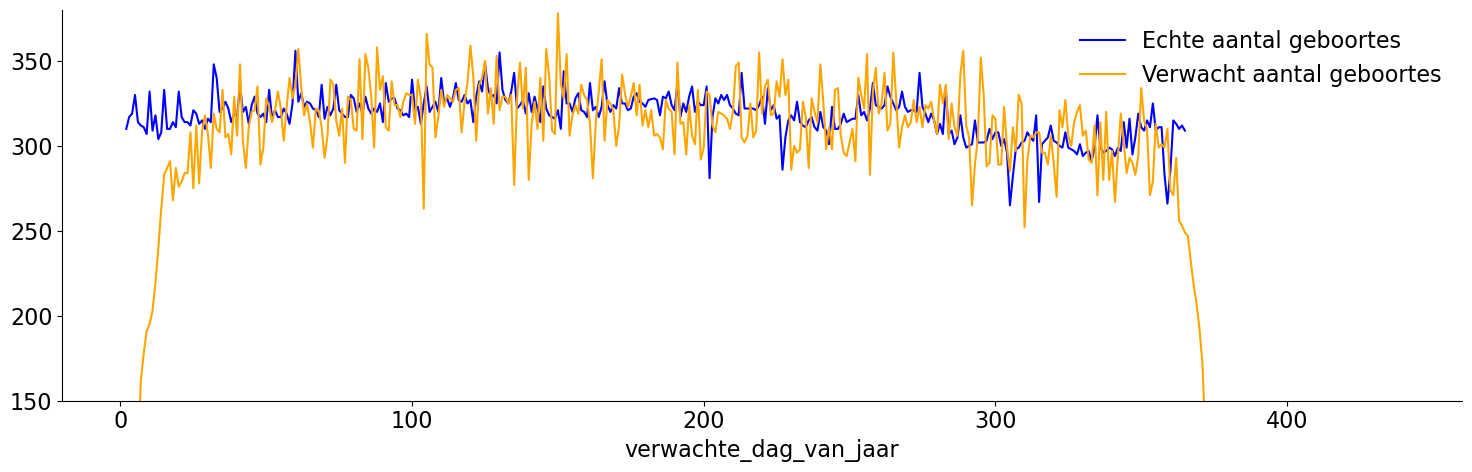

In [217]:
# Group by the day of the year and count the number of births
actual_counts = geboortes_clean.groupby('dag_van_jaar').size()
expected_counts = geboortes_clean.groupby('verwachte_dag_van_jaar').size()

# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(actual_counts.index, actual_counts.values, label='Echte aantal geboortes', color='blue', linewidth=1.5)
plt.plot(expected_counts.index, expected_counts.values, label='Verwacht aantal geboortes', color='orange', linewidth=1.5)

# Set labels and title
plt.xlabel('verwachte_dag_van_jaar')
plt.ylim(150,380)
plt.xlim(-20, 460)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

(150.0, 380.0)

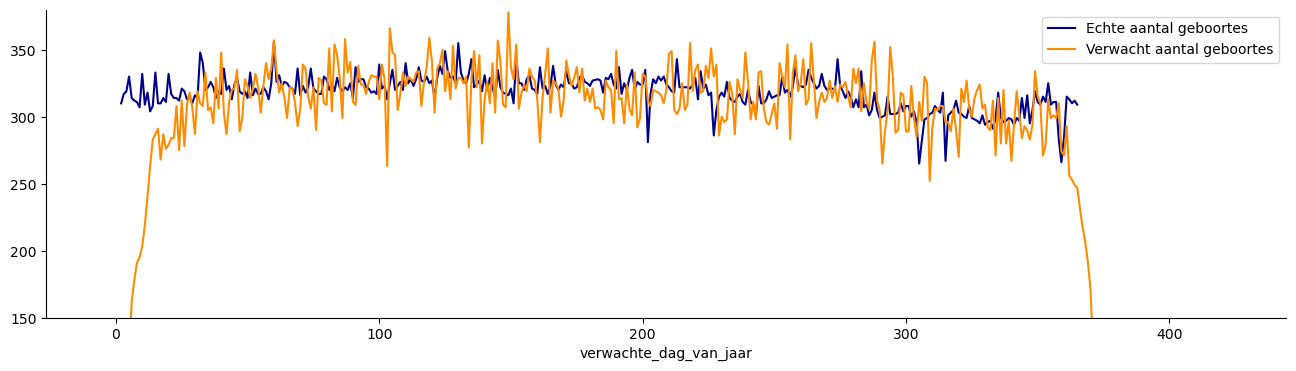

#### Verbanden bekijken
Maak een histogram van het aantal dagen dat babies te vroeg geboren werden in 2019 en een scatterplot die het verband toont tussen de verwachte en effectieve geboortedatum.

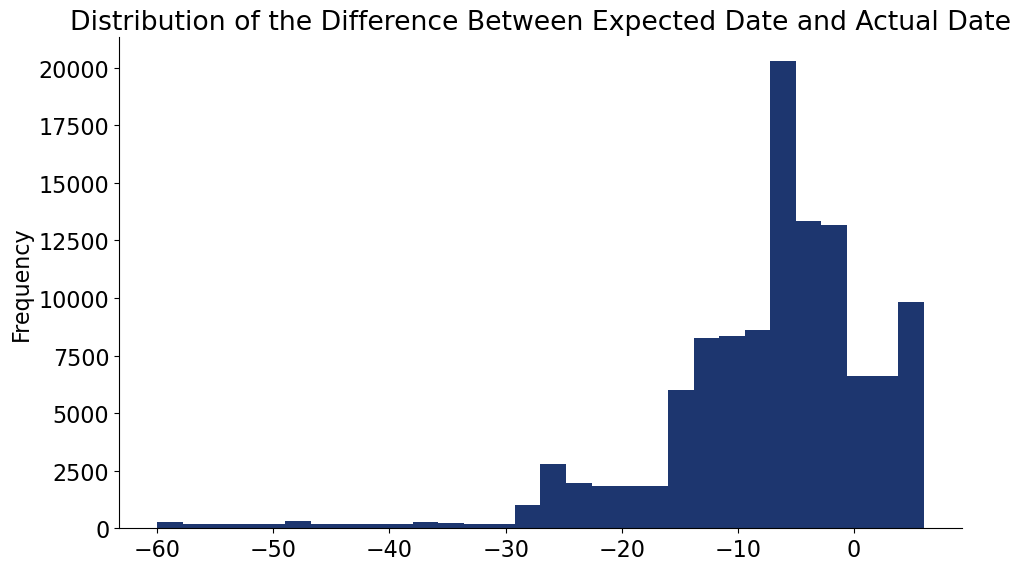

In [104]:
# Plot the distribution of the date difference
def plot_date_difference_distribution(dataframe):
    plt.figure(figsize=(10, 6))
    plt.hist(dataframe['date_diff'], bins=30)
    plt.title('Distribution of the Difference Between Expected Date and Actual Date')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_date_difference_distribution(geboortes_clean)

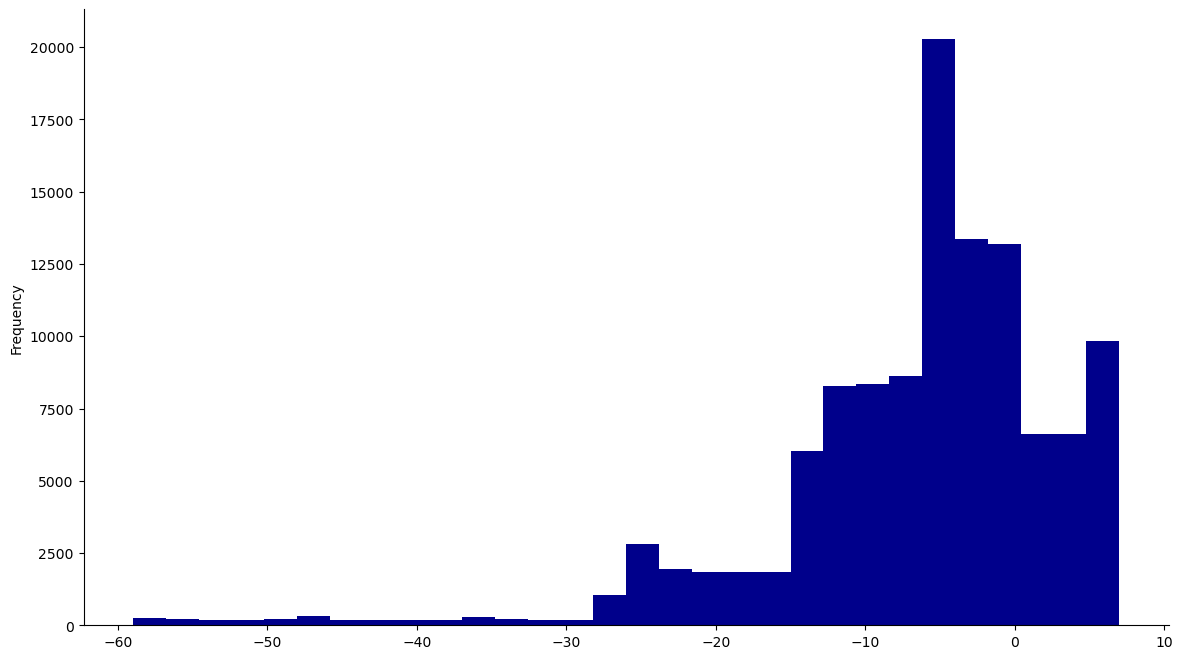

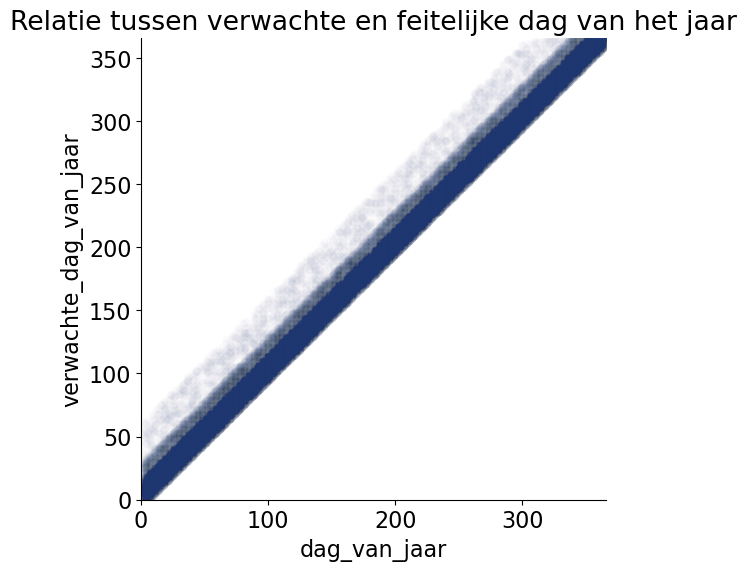

In [218]:
# Creating a scatter plot to visualize the correlation between 'verwachte_datum' and 'geboorte_datum'
plt.figure(figsize=(6, 6))
sns.scatterplot(x='dag_van_jaar', y='verwachte_dag_van_jaar', data=geboortes_clean, alpha=0.01)
plt.title('Relatie tussen verwachte en feitelijke dag van het jaar')
plt.xlabel('dag_van_jaar')
plt.ylabel('verwachte_dag_van_jaar')
plt.xlim(0, 366)
plt.ylim(0, 366)
plt.show()

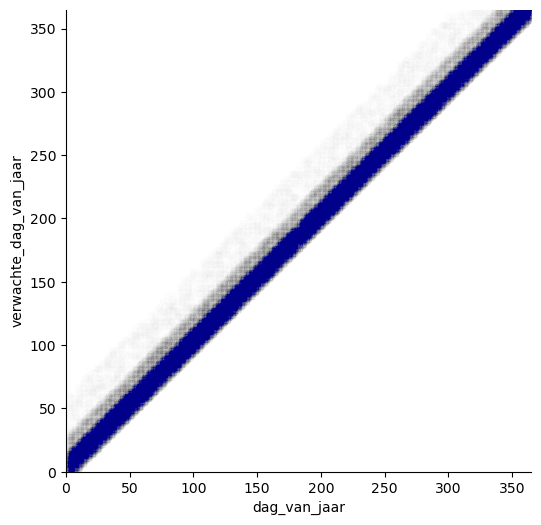

### Onderzoek 3: Aantal namen versus aantal babies
Naarmate dat er meer babies geboren worden, gaan deze ook meer verschillende namen krijgen. Zolang er weinig babies geboren worden lijkt het logisch dat dit verband min of meer lineair is, maar naarmate dat er meer en meer babies geboren worden lijkt het niet meer logisch dat dit verband lineair blijft. We verwachten bijvoorbeeld niet dat het aantal unieke namen gegeven aan 2 miljoen babies het dubbel is van het aantal unieke namen gegeven aan 1 miljoen babies. Kan je op basis van deze dataset het verband tussen het aantal unieke namen in functie van het aantal babies eens onderzoeken? Hiervoor krijg je geen voorstel tot visualizatie maar moet je zelf mij proberen te overtuigen van je antwoord.

### Antwoord: In het plot zien we het verband tussen de sample sizes en het aantal unieke namen en hoe dat evolueert tot aan de maximum sample (de feitelijke lengte van het dataframe) 

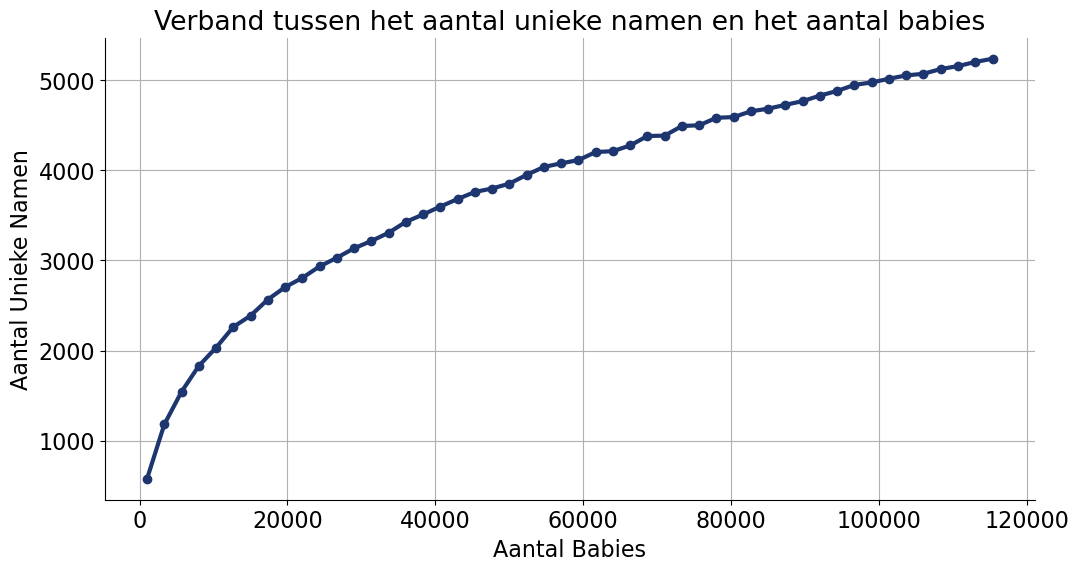

In [120]:
# Function to calculate the number of unique names for a given sample (number of births)
def compute_unique_names(df, sample_size):
    return len(df.sample(sample_size)['naam'].unique())

# Sample different sizes
sample_sizes = np.linspace(1000, len(geboortes_clean), num=50, dtype=int)

# Compute the number of unique names for each sample size
unique_names = [compute_unique_names(geboortes_clean, size) for size in sample_sizes]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, unique_names, marker='o')
plt.xlabel('Aantal Babies')
plt.ylabel('Aantal Unieke Namen')
plt.title('Verband tussen het aantal unieke namen en het aantal babies')
plt.grid(True)
plt.show()

### Wanneer we willen zien hoe de data verder evolueert moeten we gebruik maken van polynomiale regressie.

Best polynomial degree: 3 with cross-validation error: 121065.41600882467


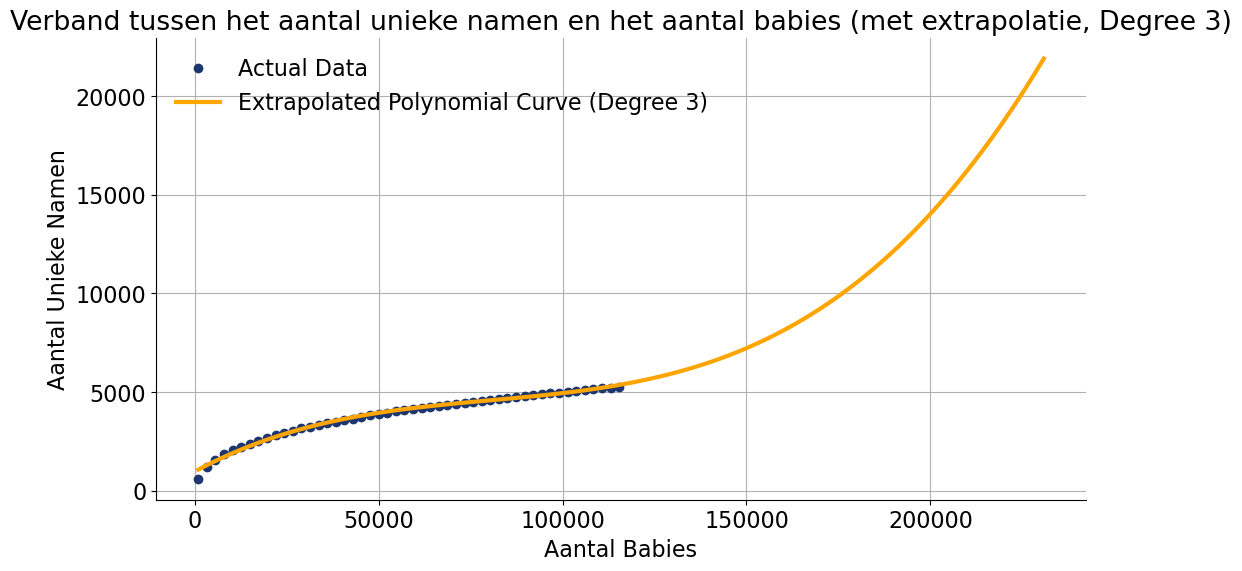

In [177]:
# Prepare data: Sort by geboorte datum to simulate growing number of births over time
geboortes_clean = geboortes_clean.sort_values('geboorte_datum')

# Function to calculate the number of unique names for a given number of births
def compute_unique_names(data, n_births):
    return len(data.head(n_births)['naam'].unique())

# Sample different sizes
sample_sizes = np.linspace(1000, len(geboortes_clean), num=50, dtype=int)

# Compute the number of unique names for each sample size
unique_names = np.array([compute_unique_names(geboortes_clean, size) for size in sample_sizes])

# Function to fit polynomial regression and calculate cross-validation error
def fit_polynomial_regression(degree, X, y):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    model = LinearRegression()
    cv_error = -np.mean(cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error'))
    model.fit(X_poly, y)
    return model, poly, cv_error

# Test different polynomial degrees and select the best one
degrees = range(1, 10)
errors = []
models = []
polynomials = []

for degree in degrees:
    model, poly, cv_error = fit_polynomial_regression(degree, sample_sizes, unique_names)
    errors.append(cv_error)
    models.append(model)
    polynomials.append(poly)

# Select the best model
best_degree = degrees[np.argmin(errors)]
best_model = models[np.argmin(errors)]
best_poly = polynomials[np.argmin(errors)]

print(f"Best polynomial degree: {best_degree} with cross-validation error: {min(errors)}")

# Extrapolate to larger numbers of births
extrapolated_sample_sizes = np.linspace(1000, 2 * len(geboortes_clean), num=100, dtype=int)
X_extrapolated_poly = best_poly.transform(extrapolated_sample_sizes.reshape(-1, 1))
extrapolated_unique_names = best_model.predict(X_extrapolated_poly)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, unique_names, marker='o', linestyle='', label='Actual Data')
plt.plot(extrapolated_sample_sizes, extrapolated_unique_names, label=f'Extrapolated Polynomial Curve (Degree {best_degree})', color='orange')
plt.xlabel('Aantal Babies')
plt.ylabel('Aantal Unieke Namen')
plt.title(f'Verband tussen het aantal unieke namen en het aantal babies (met extrapolatie, Degree {best_degree})')
plt.grid(True)
plt.legend()
plt.show()